In [0]:
import numpy as np
from pathlib import Path
import os
import pyspark
from base64 import b64decode
from PIL import Image
import random
import cv2
from pyspark.ml.image import ImageSchema
import errno
import albumentations as albu

#! pip install -U albumentations


In [0]:
#!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip

In [0]:
sp_df = spark.read.format("image").load("/data_dir/val2014")

In [0]:
sp_df.count()

Out[10]: 40504

In [0]:
sp_df.show(5)

+--------------------+
|               image|
+--------------------+
|{dbfs:/data_dir/v...|
|{dbfs:/data_dir/v...|
|{dbfs:/data_dir/v...|
|{dbfs:/data_dir/v...|
|{dbfs:/data_dir/v...|
+--------------------+
only showing top 5 rows



In [0]:
#make directory
try:
    os.mkdir('../../dbfs/data_dir/val2014/gray_scale_laplacian_output')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass


In [0]:
rdd_1 = sp_df.rdd

In [0]:
def apply_grayscale_laplacian(row):
    '''
    The function reads the image and first convert RGB image
    into gray scale image followed by applying Laplacian transform
    input image :row vector
    output image:2D numpy array
    '''
    height = row.image.height
    width = row.image.width
    data = row.image.data
    try:
        if ((height and width and data) is not None):
            img_np = np.frombuffer(data, dtype=np.uint8)
            img = img_np.reshape(height,width, 3) 
            
            #using average method to gray out
            img[:] = np.sum(img,axis=-1,keepdims=1)/3
            im = Image.fromarray(img[:])
            
            #Applying Laplacian Transform
            img_s = cv2.Laplacian(im, cv2.CV_16S, ksize=3)
            img_s = cv2.convertScaleAbs(img_s)
            img_name = os.path.basename(row.image.origin)
            
            abs_path_3 = '/dbfs/data_dir/val2014/gray_scale_laplacian_output/'+ img_name
            im = Image.fromarray(img_s)
            im.save(abs_path_3)
            im.save(abs_path)
            return abs_path
    except Exception as e:
        pass

In [0]:
t1 = rdd_1.map(lambda x:apply_grayscale_laplacian(x))


In [0]:
t1.collect()

Out[16]: ['/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000317595.jpg',
 None,
 None,
 None,
 None,
 None,
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000189773.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000026617.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000526955.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000156232.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000554805.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000409850.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000442306.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000472942.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000220171.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000529670.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_000000085005.jpg',
 '/dbfs/data_dir/val2014/gray_scale_output/COCO_val2014_

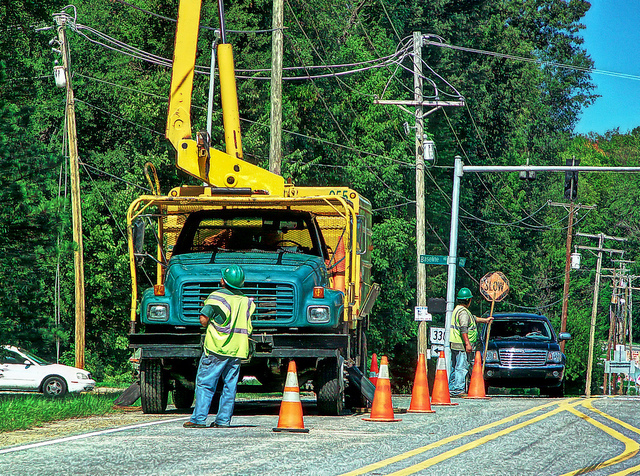

Out[28]: (640, 476)

In [0]:
#Input Image

image = Image.open('/dbfs/data_dir/val2014/COCO_val2014_000000472942.jpg')
image.show()
image.size

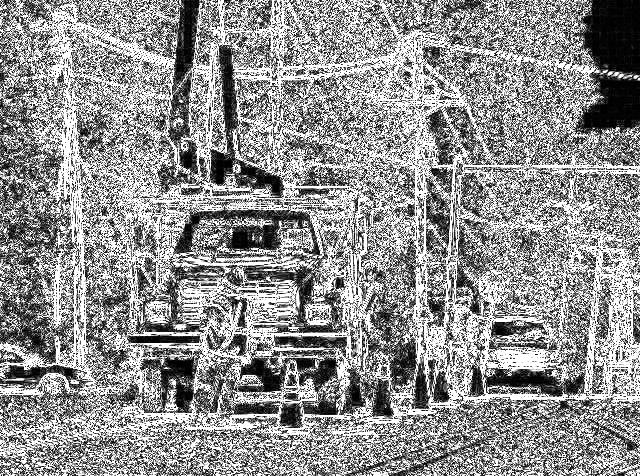

Out[30]: (640, 476)

In [0]:
#Output Image after applying gray scale and laplacian Transform

image = Image.open('/dbfs/data_dir/val2014/gray_scale_laplacian_output/COCO_val2014_000000472942.jpg')
image.show()

image.size


In [0]:
#Albumenations

from albumentations import (
 Compose,
 OneOf,
 RandomBrightnessContrast,
 RandomGamma,
 ShiftScaleRotate,
)

In [0]:
#make directory
try:
    os.mkdir('../../dbfs/data_dir/val2014/alb_output')
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

In [0]:
def get_augmentation(row):
    """
    The function performs data augmentation 
    and retuns the output augmented image
    input:row vector
    output:2D numpy array
    """
    height = row.image.height
    width = row.image.width
    data = row.image.data
    try:
        if ((height and width and data) is not None):
            img_np = np.frombuffer(data, dtype=np.uint8)
            img = img_np.reshape(height,width, 3)
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            image = np.array(image)
            
            transform = albu.Compose([
                albu.Resize(320,238),
                albu.ShiftScaleRotate(scale_limit=0.20, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
                albu.HorizontalFlip(p=0.3),
                albu.VerticalFlip(p=0.5),
                albu.RandomCrop(310,228),
                albu.GaussianBlur(blur_limit=(3,3),p=0.1),
                albu.RGBShift(p=0.7),
                albu.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=True, p=0.5),
                albu.RandomBrightness(limit=(0.2,0.5),p=0.3),
                albu.RandomContrast(limit=(0.2,0.5),p=0.3),
                albu.HueSaturationValue(p=0.5)])

            augmented_image = transform(image=image)['image']
            img_name = os.path.basename(row.image.origin)
            abs_path_4 = '/dbfs/data_dir/val2014/alb_output/'+ img_name           
            im_tran = Image.fromarray(augmented_image)
            im_tran.save(abs_path_4)
        return abs_path_4
    
    except Exception as err: 
        pass

In [0]:
sp_alb = sp_df

In [0]:
rdd_2 = sp_alb.rdd

In [0]:
t2 = rdd_2.map(lambda x:get_augmentation(x))

In [0]:
t2.collect()

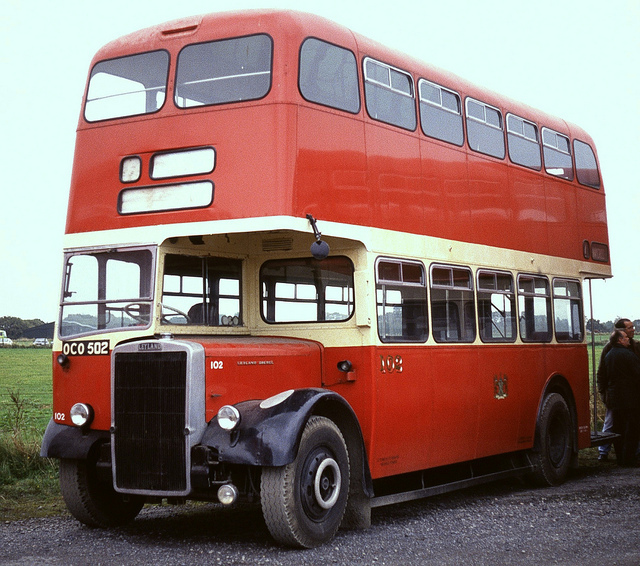

Out[43]: (640, 566)

In [0]:
image = Image.open('/dbfs/data_dir/val2014/COCO_val2014_000000189773.jpg')
image.show()
image.size

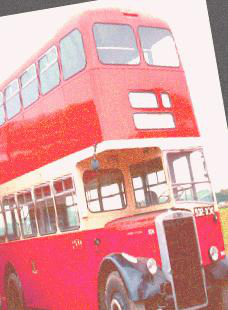

Out[41]: (228, 310)

In [0]:
image = Image.open('/dbfs/data_dir/val2014/alb_output/COCO_val2014_000000189773.jpg')
image.show()
image.size